<h1> Importing The Dependencies

In [1]:
import numpy as np
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Input, merge
from keras.layers import Reshape,LeakyReLU,ZeroPadding2D
from keras.layers.core import Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Deconvolution2D
from keras.layers.core import Flatten
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import SGD, Adagrad
from PIL import Image
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.objectives import binary_crossentropy
import tensorflow as tf
#from tqdm import tqdm
import scipy.misc as im
K.set_image_dim_ordering('tf') 
IN_CH = 3

Using TensorFlow backend.


In [2]:
import numpy as np
import glob, pickle
import os, sys
import argparse
#import cv2
from keras.models import Sequential, Model
from keras.layers import Dense, Input, merge
from keras.layers import Reshape
from keras.layers.core import Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Deconvolution2D
from keras.layers.core import Flatten
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import SGD, Adagrad
from PIL import Image
from keras import backend as K
from keras.layers.normalization import BatchNormalization
import math
K.set_image_dim_ordering('tf') 

img_rows = 256
img_cols = 256
SHAPE = 256
BATCH = 4
IN_CH = 3
OUT_CH = 3
LAMBDA = 100
NF = 64 # number of filter
BATCH_SIZE = 10


<h1> Code for getting all the training images and splitting them into :
<h2>  Input (Face)
<h2>  Output(High level representation of face)

In [ ]:
def split_input(img,mode='AtoB'):
    """
    img: an 512x256x3 image
    :return: [input, output]
    """
    input, output = img[:,:img_cols,:], img[:,img_cols:,:]

    if mode == 'BtoA':
        input, output = output, input
    return [input, output]

def get_data(datadir):
    #datadir = args.data
    # assume each image is 512x256 split to left and right
    imgs = glob.glob(os.path.join(datadir, '*.jpg'))
    data_X = np.zeros((len(imgs),img_rows,img_cols,3))
    data_Y = np.zeros((len(imgs),img_rows,img_cols,3))
    i = 0
    for file in imgs:
        #img = cv2.imread(file,cv2.IMREAD_COLOR)
        img=Image.open(file)
        img = img.resize((img_cols*2, img_rows), Image.LANCZOS)
        
        img = np.array(img)
        #img = cv2.resize(img, (img_cols*2, img_rows)) 
        #print('{} {},{}'.format(i,np.shape(img)[0],np.shape(img)[1]))
        

        X, Y = split_input(img)

        data_X[i,:,:,:] = X
        data_Y[i,:,:,:] = Y
        i = i+1
    return data_X, data_Y

<h1>Applying the above function
<h2> data_x contains input image (to be fed into generator)
<h2> data_y contains output image (generator image should be like this)

In [7]:
data_x,data_y=get_data('train')


<h1> Dependencies (Some of them are only in keras 2.0 )

In [39]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras.layers.merge import Concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model

<h1> Code for generator 

In [40]:
def generator_model():
    
    input_tensor = Input(shape=(img_rows,img_cols,IN_CH)) # type: Input
    output_ch = 3
    filters=128
    x =                       Conv2D(         filters*1, kernel_size=(4, 4), strides=(2, 2), padding="same")( input_tensor )       ; e1 = x
    x = BatchNormalization()( Conv2D(         filters*2, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e2 = x
    x = BatchNormalization()( Conv2D(         filters*4, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e3 = x
    x = BatchNormalization()( Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e4 = x
    x = BatchNormalization()( Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e5 = x
    x = BatchNormalization()( Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e6 = x
    x = BatchNormalization()( Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e7 = x
    x =                       Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) )  ; e8 = x
    # dec
    x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e7])
    x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e6])
    x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e5])
    x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([x, e4])
    x = BatchNormalization()( Conv2DTranspose(filters*4, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([x, e3])
    x = BatchNormalization()( Conv2DTranspose(filters*2, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([x, e2])
    x = BatchNormalization()( Conv2DTranspose(filters*1, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([x, e1])
    x =                       Conv2DTranspose(output_ch, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) )
    
    x = Activation("tanh")(x)
    
    unet = Model(inputs=input_tensor, outputs=x)
    
    return unet

<h1> Examining every layer of generator 

In [41]:
gx=generator_model()
gx.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 128, 128, 128)     6272      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 64, 64, 256)       524544    
_________________________________________________________________
batch_normalization_53 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 512)       2097664   
__________

<h1>Code for discriminator

In [42]:
def discriminator_model():    
    inputs = Input(shape=(img_cols,img_rows,IN_CH*2))
    d = ZeroPadding2D(padding=(1,1))(inputs)
    d = Conv2D(64, kernel_size=(4, 4), strides=(2, 2))(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = ZeroPadding2D(padding=(1,1))(d)
    d = Conv2D(128, kernel_size=(4, 4), strides=(2, 2))(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = ZeroPadding2D(padding=(1,1))(d)
    d = Conv2D(256, kernel_size=(4, 4), strides=(2, 2))(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = ZeroPadding2D(padding=(1,1))(d)
    d = Convolution2D(512, kernel_size=(4, 4), strides=(1, 1))(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = ZeroPadding2D(padding=(1,1))(d)
    d = Convolution2D(1, kernel_size=(4, 4), strides=(1, 1),activation='sigmoid')(d)
    model = Model(inputs,d)
    return model

<h1> Examining every layer of discriminator

In [43]:
dx=discriminator_model()
dx.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 256, 256, 6)       0         
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 258, 258, 6)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 128, 128, 64)      6208      
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 130, 130, 64)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 64, 64, 128)       0         
__________

<h1> Connecting them together 
<h2>(Actually this will be used to train the generator)

In [44]:
def generator_containing_discriminator(generator, discriminator):
    inputs = Input((img_cols, img_rows,IN_CH))
    x_generator = generator(inputs)
    merged=Concatenate()([inputs, x_generator])
    #merged = merge([inputs, x_generator], mode='concat',concat_axis=-1)
    discriminator.trainable = False
    x_discriminator = discriminator(merged)
    
    model = Model(inputs,[x_generator,x_discriminator])
    
    return model

<h1> Examining the details behind the combination

In [45]:
gcd=generator_containing_discriminator(gx,dx)
gcd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
model_13 (Model)             (None, 256, 256, 3)       217648387 
_________________________________________________________________
concatenate_40 (Concatenate) (None, 256, 256, 6)       0         
_________________________________________________________________
model_14 (Model)             (None, 30, 30, 1)         2767809   
Total params: 220,416,196.0
Trainable params: 220,396,484.0
Non-trainable params: 19,712.0
_________________________________________________________________


<h1> Loss for Discriminator
<h2> (Binary cross entropy)

In [46]:
def discriminator_on_generator_loss(y_true,y_pred):
    return K.mean(K.binary_crossentropy(y_pred,y_true), axis=(1,2,3))



<h1> Loss for generator 
<h2> Simply a l1 loss

In [ ]:
def generator_l1_loss(y_true,y_pred):
    return K.mean(K.abs(y_pred - y_true),axis=(1,2,3))

<h1>  function for saving images at a particular epoch 

In [47]:
def generate_pic(generator,target,filename):
    pic = generator.predict(target)
    pic=pic*127.5+127.5
    pic = np.squeeze(pic,axis=0)
    #target = np.squeeze(target,axis=0)
    #im.imsave('target_%d_%d.png' % (e,n),target)
    #filename='pic'+str(n)+'.png'
    #gg=os.path.join(paths, filename)
    #print('done')
    im.imsave(filename,pic)


<h1> Training Code 

In [52]:
def train(epochs,batchsize):
    
    
    # Calling the above function for getting training data
    target,pic=get_data('train')
    
    
    # we should convert them into float before feeding into the model
    pic = pic.astype('float32')
    target = target.astype('float32')
    
    
    # Again we should normalize it between [-1,1]
    pic = (pic - 127.5) / 127.5
    target = (target - 127.5) / 127.5
    
    # The number of batches in a particular epoch will be calculated as  
    batchCount = int(pic.shape[0] / batchsize)
    
    
    # printing the number of epochs,batch size ,batch per epoch 
    print('Epochs  ',epochs)
    print('Batch_size   ',batchsize)
    print('Batches per epoch    ',batchCount)
    
    
    # This for applying the generator model on test set
    # Note : It is only applied after every 10th epoch
    target2,pic2=get_data('test')
    
    # Creating Generator Model 
    generator = generator_model()
    
    # Creating Discriminator Model
    discriminator = discriminator_model()
    
    # Combining Both of them
    gan = generator_containing_discriminator(generator,discriminator)
    
    # Assigning Loss and optimizer to Generator 
    generator.compile(loss=generator_l1_loss, optimizer='RMSprop')
    
    # Assigning Loss and optimizer to Their Combination 
    # Note 1:Every time this model is created discriminator weights are set to Non trainable
    # Because that will be Not allowing the generator to learn or  simply unfair
    
    # Note 2 : since gan takes both of them as inputs there will also be cobination of losses 
    gan.compile(loss=[generator_l1_loss,discriminator_on_generator_loss] , optimizer='RMSprop')
    
    
    # Now the weights can be set to trainable because its now discriminator's turn
    discriminator.trainable = True
    
    # Assigning the discriminator its optimizer and loss
    discriminator.compile(loss=discriminator_on_generator_loss, optimizer='RMSprop')
    
    
    # This array records generator loss for every epoch 
    G_loss = []
    
    
    # This array records discriminator loss for every epoch
    D_loss = []
    for e in range(1,epochs+1):
        
        # ( Helpful for keeping a track of current epoch    )
        print('Epoch       {}',e)
        
        # inner loop (This loop is runs upto number of batches )
        for nums in range(batchCount):
            # Generate a random number (Output will be collection of m number of batches each having
            #  batch size size n and n X m=t : t is number training examples  )
            random_number = np.random.randint(1,pic.shape[0],size=batchsize)
            
            # this is a random batch of output
            batch_pic = pic[random_number]
            
            # this is a random batch of input
            batch_target = target[random_number]
            
            # replicate this using tile because we need  a pair to supply to the discriminator 
            batch_target2 = np.tile(batch_target,(2,1,1,1))
            
            # One Batch will be for generated images (fake)
            # their probablity will be   zero
            y_dis = np.zeros((2*batchsize,30,30,1))
            
            # the other half will be for real hence all one 
            # note : this is ideal output not the actual output
            # this is used to calculate the value of loss
            y_dis[:batchsize] = 1.0
            
            
            # generate for all the batch of input images
            generated_pic = generator.predict(batch_target)
            
            
            #Concatenation default along first dimension
            concat_pic = np.concatenate((batch_pic,generated_pic))
            # this results in input images and the corressponding generated images
            
            # We need to feed two things to discriminator 
            #  1. Concat_pic calculated from above (discrinator should give thm low  scores)
            # 2. batch_target 2 
            # Note We are feeding pair wise ie. generated->input and real->input
            # we will concate nate along third dimension
            dis_input = np.concatenate((concat_pic,batch_target2),axis=-1)
            
            # to calculate loss we feed it to discriminator 
            # y_dis will be used to calculate the loss 
            dloss = discriminator.train_on_batch(dis_input,y_dis)
            
            
            # again taking a random batch 
            random_number = np.random.randint(1,pic.shape[0],size=batchsize)            
            train_target = target[random_number]
            batch_pic = pic[random_number]
            
            
            y_gener = np.ones((batchsize,30,30,1))
            
            # Discrinator will not be trained here  thats unfair
            discriminator.trainable = False
            
            # Now training for generator 
            gloss = gan.train_on_batch(train_target,[batch_pic,y_gener])
            
            # now we can set it to true for the next batch
            discriminator.trainable = True
        if e%10==0:
            # Code for results of particular epoch 
            paths = 'images'+str(e)
            if os.path.isdir(paths)==False:
                os.mkdir(paths)
            for k in range(pic2.shape[0]):
                filename='pic'+str(k)+'.png'
                gg=os.path.join(paths, filename)
                generate_pic(generator,target2[k:k+1],gg) 
                
        # this particular epoch is over save the losses
        G_loss.append(gloss)
        D_loss.append(dloss)
        
        # save the final model if this is the last epoch
        if e % epochs == 0:
            #generator.save('g%d.h5' % e)
            generator.save_weights('generator', True)
            discriminator.save_weights('discriminator', True)
            gan.save_weights('gan', True)
            
    # Training is over saving losses to numpy file
    D_loss = np.array(D_loss)
    G_loss = np.array(G_loss)
    np.save('dloss.npy',D_loss)
    np.save('gloss.npy',G_loss)

<h1> Calling the train function  

In [ ]:
train(150,10)

<h1> Plotting generator loss

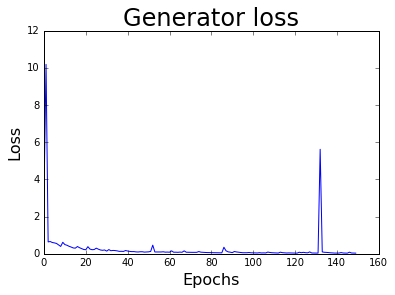

In [4]:

import numpy as np
G=np.load('gloss.npy')
#D
import matplotlib.pyplot as plt
% matplotlib inline 
plt.plot(G[:,0])
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Generator loss',fontsize=24)
plt.show()

<h1>Plotting Discriminator Loss

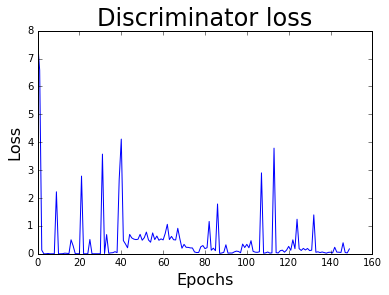

In [5]:
import numpy as np
G=np.load('dloss.npy')
#D
import matplotlib.pyplot as plt
% matplotlib inline 
plt.plot(G[:])
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Discriminator loss',fontsize=24)
plt.show()